# Scikit-learn

* Provides a very large library of routines to perform machine learning.
  * Pre-processing, feature extraction, clustering, classification, regression, hyper-paramter tuning, etc.
  * Doesn't really do CGANs or U-Nets. (Tensorflow provides implementations of these.)

# Data Convention

* Most routines/classes in Scikit-learn assume that your data is provided as a 2D array where the first dimension(rows) represents each data sample and the second dimension(columns) represents each feature(predictor).
* In general, most of the code in a machine learning project will be used to generate this table from your various data sources.  Frequetly, 10-20 lines of code will be scikit-learn calls. 

# Estimator, Predictor, and Transformer Objects
* Most of Scikit-learn's functionality is provided by classes that belong to one or more of the [above groups](https://scikit-learn.org/stable/developers/develop.html#apis-of-scikit-learn-objects).

## Estimator
* An object is considered an `Estimator` if it provides a `fit` method that learns something from given data:
  * `estimator.fit(data, targets)` or `estimator.fit(data)` 

## Predictor
* An object is considered a `Predictor` if it provides a `predict` method to provide a prediction/estimate given some data.
  * `prediction = predictor.predict(data)`
  * Frequently, a `predict_proba` method will also be provided to generate a probability associated with the prediction. (The precise interpretation should be examined in the documentation for the `Predictor` you're using.)

## Transformer
* An object is considered a `Transformer` if it provides a `transform` method that alters the input data in some way.
  * `new_data = transformer.transform(data)`

## Examples
* A lot of the classes you'll encounter are both estimators and transformers or estimators and predictors.
* EX: Principle Component Analysis(PCA) is impelmented in scikit-learn as a class that provides both a `fit` and `transform` method.  So this makes it both an estimator *and* a transformer.
* EX: Linear Regression provides both a `fit` and `predict` method, so it is both an estimator *and* a predictor.



# Toy Classification Example

* Let's run through a simple classification problem.
* We'll have samples of data with two predictors and one classification.
* We'll keep this easy so data belonging to a given classification will be easy to distinguish from the other two classifications.
* We'll train a machine learning algorithm to predict the classification given a new sample of predictors.

## Read Some Fake Data
* We have three, easily separated, classes of data.
  * These were made by sampling three 2D gaussians.
* We'll extract the predictors from a DataFrame to an array that has a shape: n_samples x n_predictors. 
  * In this case this it will be 900x2
* We'll also store classifications for each sample in a separate 1D array that's n_samples long.

predictor1  predictor2  classification
index                                        
0       -9.100339   22.915218               0
1       -8.746883   21.193243               0
2       -9.404241   21.353608               0
3       -9.953072   21.966530               0
4      -10.662349   20.547734               0
...           ...         ...             ...
895    -29.874018   12.738374               2
896    -34.413369   11.835923               2
897    -35.157229   11.664754               2
898    -33.643168   21.570007               2
899    -37.668810   12.931427               2

[900 rows x 3 columns]

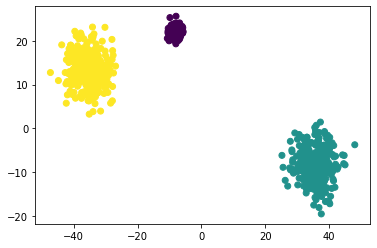

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

fake_dataset = pd.read_csv(
    "http://rammb-data.cira.colostate.edu/~rdemaria/week_22_sklearn_fake_data.csv", 
    index_col="index")
display(fake_dataset)

fake_predictors = fake_dataset[["predictor1", "predictor2"]].to_numpy()
fake_classifications = fake_dataset["classification"].to_numpy()

plt.scatter(fake_predictors[:, 0], fake_predictors[:, 1], c=fake_classifications)
plt.show()


# Separating Data Into Training/Testing Sets
* In order to train and evaluate our model, we'll need to randomly divide our data into a training set and a testing set.
* If each of your samples are independent from each-other you can use sklearn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn-model-selection-train-test-split) routine to randomly split your data into the two sets.
  *  If you're working with something like TC data where all the samples belonging to a given storm need to be in either the training set or the testing set then you'll need to write your own routine to generate the datasets.
  * Otherwise, `sklearn.model_selection.train_test_split` can be used.

In [19]:
from sklearn import model_selection
# Split data into training and testing arrays.
# Need to give it the ratio of testing data to training data. (Here, 30% of the data will be used for testing)
# We're also specifying a "random_state" so that it produces the same set of data every time we run the routine.
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    fake_predictors, fake_classifications, test_size=0.3, random_state=1)
print("X Train Shape:", x_train.shape)
print("Y Train Shape:", y_train.shape)
print("X Test Shape:", x_test.shape)
print("Y Test Shape:", y_test.shape)

X Train Shape: (630, 2)
Y Train Shape: (630,)
X Test Shape: (270, 2)
Y Test Shape: (270,)


# Training A Classification Algorithm
* Let's create some estimators/transformers that will normalize our data and then perform Linear Discriminant Analysis to classify our data.

In [20]:
from sklearn import preprocessing, discriminant_analysis

# Create a "StandardScaler" that will normalize our data so it has a mean 
# of 0 and a standard deviation of 1.
scaler = preprocessing.StandardScaler()
# Create LDA
lda = discriminant_analysis.LinearDiscriminantAnalysis()

# Train our scaler, then use it to normalize our predictors
scaler.fit(x_train)
norm_x = scaler.transform(x_train)

# Train LDA
lda.fit(norm_x, y_train)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

# Evaluating the Trained Model

* Now that we have a trained model we need to see how well it did.
* We use the `predict` method to obtain an estimated classification on our testing data.
* scikit-learn has a number of routines for obtaining error metrics in the [metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) module.
* We'll take a look at the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn-metrics-confusion-matrix).


In [21]:
from sklearn import metrics

norm_test_x = scaler.transform(x_test)
estimated_classifications = lda.predict(norm_test_x)

confusion = metrics.confusion_matrix(y_test, estimated_classifications)
print(confusion)

[[91  0  0]
 [ 0 83  0]
 [ 0  0 96]]


# Pipelines

* You can work with all of your estimators/transformers/etc individually.
* It's frequently easier to work with them as a group.
* Let's create a pipeline that normalizes our data and then uses Linear Discriminant Analysis to classify our data.

In [22]:
from sklearn import preprocessing, discriminant_analysis, pipeline

# Create the individual steps of the pipeline
# Each step needs to be an "estimator", all but the last step also needs to be 
# a "transformer".
scaler = preprocessing.StandardScaler()
lda = discriminant_analysis.LinearDiscriminantAnalysis()

# Create our pipeline
steps = pipeline.Pipeline([
                           ("normalize", scaler), 
                           ("classifiy", lda)
                          ])

# Train our pipeline
# When we call "fit" on the pipeline, each step of the pipeline will have its 
# "fit" method called followed by "transform". The "transformed" output will be 
# used as input to the next step's
# "fit" and transform methods.
steps.fit(x_train, y_train)
estimated_classifications = steps.predict(x_test)
confusion = metrics.confusion_matrix(y_test, estimated_classifications)
print(confusion)


[[91  0  0]
 [ 0 83  0]
 [ 0  0 96]]


# Hyper-parameter Tuning
* In the previous example, our pipeline steps didn't really have any parameters.
* So let's switch from LDA which doesn't have a lot of parameters to random forest which has several.
* How do we determine what is the best set of parameters for our model?  
* You run it a bunch of times and see what parameters result in the best error metrics.
* scikit-learn has a number of utilites to help automate this process:
  * [Exhaustive Grid Search](https://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search): Searches every combination of parameters you want to optimize.
  * [Randomized Search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization): Randomly sample a set of parameters you want to search.
  * [Succesive Halving Search](https://scikit-learn.org/stable/modules/grid_search.html#searching-for-optimal-parameters-with-successive-halving): Iteratively search for optimal parameters by starting with large changes to parameters and then narrowing in on smaller and smaller changes to paramaters.
* We'll go over grid search.

In [23]:
from sklearn import ensemble
import pandas as pd

scaler = preprocessing.StandardScaler()
forest = ensemble.RandomForestClassifier()
steps = pipeline.Pipeline([("normalize", scaler), ("forest", forest)])
# We create a dictionary of parameters to search.
# The keys consist of the name of the pipeline step + two underscores + the name of the paramter.
# The values are a list of parameters to use.
params = {"forest__n_estimators": [10, 100, 200], "forest__max_depth": [None, 2, 10, 50]}

# We give grid search our pipeline, the scoring method it will use 
# (you can provide a scoring function or a name from the list here:
# https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values), 
# and the number of processors it will use where -1 tells it to use all 
# available processors.
grid_cv = model_selection.GridSearchCV(steps, params, scoring="accuracy", n_jobs=-1)
grid_cv.fit(x_train, y_train)
pd.DataFrame(grid_cv.cv_results_)


mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0        0.036653      0.015511  ...        0.003175               10
1        0.245759      0.005876  ...        0.000000                1
2        0.484355      0.011388  ...        0.000000                1
3        0.026127      0.001854  ...        0.006349               12
4        0.241527      0.010951  ...        0.000000                1
5        0.475009      0.003592  ...        0.000000                1
6        0.027187      0.001139  ...        0.003175               10
7        0.244591      0.003827  ...        0.000000                1
8        0.490741      0.013182  ...        0.000000                1
9        0.027396      0.001723  ...        0.000000                1
10       0.242383      0.005768  ...        0.000000                1
11       0.447426      0.058549  ...        0.000000                1

[12 rows x 15 columns]

# Storing Trained Models

* Once you have a trained model, it's likely you'll want to deploy it somewehere to generate estimates on new data.
* This means you'll have to store your model.  
* There are a number of ways to do this, each with their own tradeoffs.

## Retrain Your Model Every Time.
* One method for deploying your model is simply to include your training data with your code and train your model every time it needs to run.
* If your training data isn't too big and it doesn't take too long to train your model, then this is often the simplest solution.

## Use Python's Pickle Library
* Python comes with a library called `pickle` that can take most Python objects and represent them as a binary string.  You can write that string to a file and later use `pickle` to restore the binary string back into an object.
* The `pickle` library makes writing complex data to disk trivial but it has some large drawbacks.
* If your version of scikit-learn changes between when the model was written and when it was read from disk, then it's likely that the model won't be able to be restored.
  * If you are deploying your model so that it runs inside a virtual machine or Docker container, then you can always ensure that the model will be "unpickled" correctly.
* There are also a couple of security concerns to be aware of as well since it is possible to insert arbitrary Python code in your file that will be executed once it's "unpickled".
  * This is *usually* a minor concern for the type of code we write since any  attacker that has the ability to alter your pickle files would already have the ability to execute arbitrary Python/shell commands.


## Write Serialization Code
* If the above two methods are inappropriate for your environment, then you can alwasy write code to inspect the attributes of your model and write/read them to/from disk.
* Incompatibilities caused by changing your code or its dependencies can be handled by your serialization routines.
* This is typically the most work of the above options but allows you to ensure long-term support for trained versions of your model.
* If you decide to use this route, you should use standard file formats whenever possible:
  * [json](https://docs.python.org/3/library/json.html#module-json)
  * [toml](https://toml.io/en/)
  * [netcdf](https://unidata.github.io/netcdf4-python/)


# Homework
1. Read the fake dataset from http://rammb-data.cira.colostate.edu/~rdemaria/week_22_sklearn_fake_data.csv.
2. Instead of performing classification, create a pipeline that uses [linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn-linear-model-linearregression). 
3. Evaluate your pipeline's performance using one of the metrics provided in the [metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#metrics-and-scoring-quantifying-the-quality-of-predictions) module
4. Extra credit: Use [random forest regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn-ensemble-randomforestregressor) and use hyperparameter tuning to optimize some of its parameters.

In [24]:
# 1. Read the fake dataset from http://rammb-data.cira.colostate.edu/~rdemaria/week_22_sklearn_fake_data.csv.
fake_dataset = pd.read_csv(
    "http://rammb-data.cira.colostate.edu/~rdemaria/week_22_sklearn_fake_data.csv", 
    index_col="index")
display(fake_dataset)

fake_predictors = fake_dataset[["predictor1", "predictor2"]].to_numpy()
fake_y = fake_dataset["classification"].to_numpy()

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    fake_predictors, fake_y, test_size=0.3, random_state=1)

predictor1  predictor2  classification
index                                        
0       -9.100339   22.915218               0
1       -8.746883   21.193243               0
2       -9.404241   21.353608               0
3       -9.953072   21.966530               0
4      -10.662349   20.547734               0
...           ...         ...             ...
895    -29.874018   12.738374               2
896    -34.413369   11.835923               2
897    -35.157229   11.664754               2
898    -33.643168   21.570007               2
899    -37.668810   12.931427               2

[900 rows x 3 columns]

In [25]:
# 2. Instead of performing classification, create a pipeline that uses linear regression.
from sklearn import linear_model

scaler = preprocessing.StandardScaler()
regression = linear_model.LinearRegression()

steps = pipeline.Pipeline([("normalize", scaler), ("regression", regression)])

steps.fit(x_train, y_train)


Pipeline(memory=None,
         steps=[('normalize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [26]:
# 3. Evaluate your pipeline's performance using one of the metrics provided in the metrics module.
estimated_y = steps.predict(x_test)
metrics.mean_absolute_error(estimated_y, y_test)

0.22606104954120554

In [28]:
# 4. Extra credit: Use random forest regression and use hyperparameter tuning to optimize some of its parameters.
scaler = preprocessing.StandardScaler()
regression = ensemble.RandomForestRegressor()

steps = pipeline.Pipeline([("normalize", scaler), ("forest", regression)])
params = {"forest__n_estimators": [10, 100, 200], "forest__max_depth": [None, 2, 10, 50]}


grid_cv = model_selection.GridSearchCV(
    steps, params, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_cv.fit(x_train, y_train)
pd.DataFrame(grid_cv.cv_results_)

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0        0.024396      0.001086  ...        0.000000                1
1        0.227079      0.002269  ...        0.002873               11
2        0.453585      0.008250  ...        0.002168               10
3        0.025338      0.001654  ...        0.007127               12
4        0.225794      0.003602  ...        0.000713                4
5        0.438185      0.005769  ...        0.001351                8
6        0.024657      0.001226  ...        0.000000                1
7        0.217810      0.004793  ...        0.000713                4
8        0.435205      0.008072  ...        0.001069                6
9        0.024099      0.001073  ...        0.000000                1
10       0.217460      0.004388  ...        0.001425                7
11       0.413781      0.041262  ...        0.001894                9

[12 rows x 15 columns]